# 2.1 Identifying $\delta$ - coupler exchange

Lets look first at the exchange with the coupler


We will consider the following solutions:

* The full 50 bit solution `50_RN`. This can be considered as a the "truth".
* The 50 bit solution , but with `agcm_to_coupler` undertaken at 10bit.
* The 50 bit solution , but with `coupler_to_agcm` undertaken at 10bit.
* The 50bit solution but with BOTH coupler subroutines at 10 bit.

Since the coupler is called at the end of every day, lets just look on the **timecale of a few days** for now

# A. Overview

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

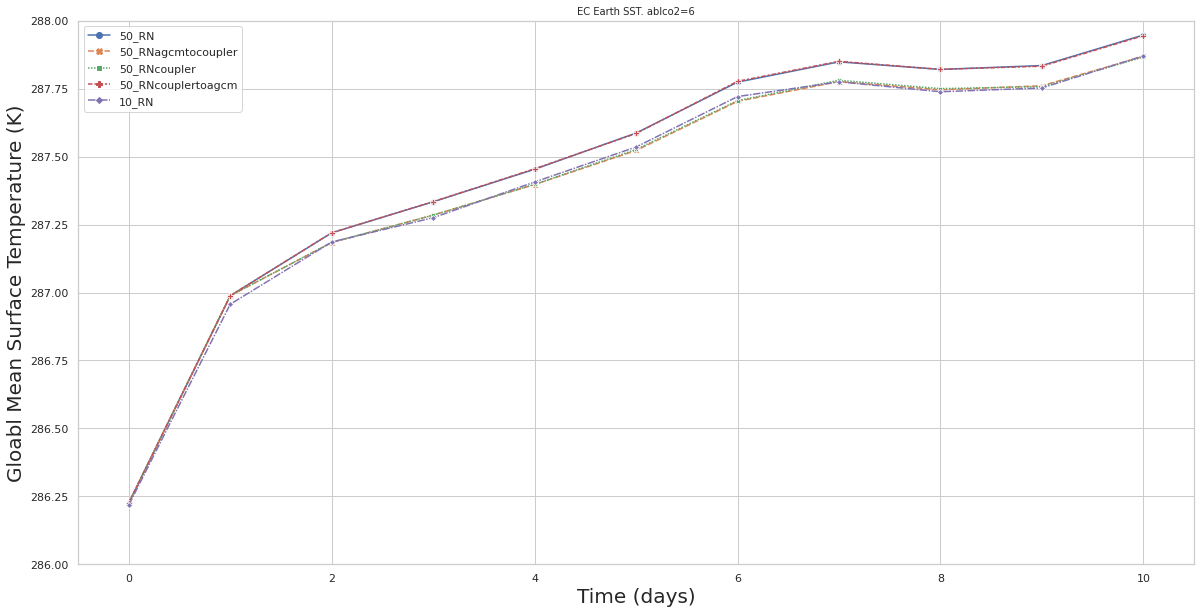

In [6]:
from scripts import *

plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(286.0,288.0),
                   'y': 'temperature'}

df_flamingo = process_and_plot('flamingo/',plot_kwargs,pd.DataFrame())


We can see an immediate divergence after 1 day when we run `agcm_to_coupler` at low precision.

This error is dominant in `10_RN` at early times i.e. the 50 bit solution with `agcm_to_coupler` at low precision is very similar to the full low precision solution, which also has error contributions from other parts of the model

---



# B. Land vs Sea

`agcm_to_coupler` has a general structure:

``` fortran

subroutine agcm_to_coupler(jday)

    ! 1. send fields to land model
    call atm2land(jday)

    ! 2. send fields to sea and ice model
    call atm2sea(jday)
    
end subroutine agcm_to_coupler


```

The question is then:

**Is this divergence due to the land model part or the sea/ice model part?**

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

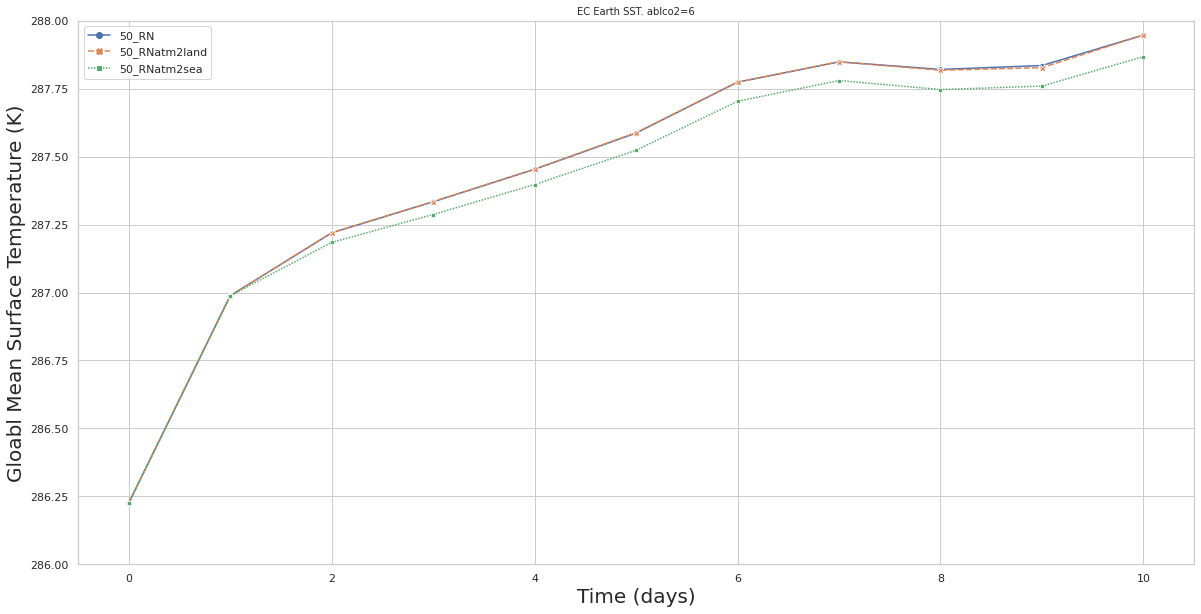

In [17]:
plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(286.0,288.0),
                   'y': 'temperature'}

df_gator = process_and_plot('gator/',plot_kwargs,pd.DataFrame())

**Exclusively the sea/ice model part!**

---

# C. Why is atm2sea giving us grief?

Now, the subroutine `atm2sea` has multiple constituent parts. By selectively altering them to low precision we can see which bit is causing this divergence:

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

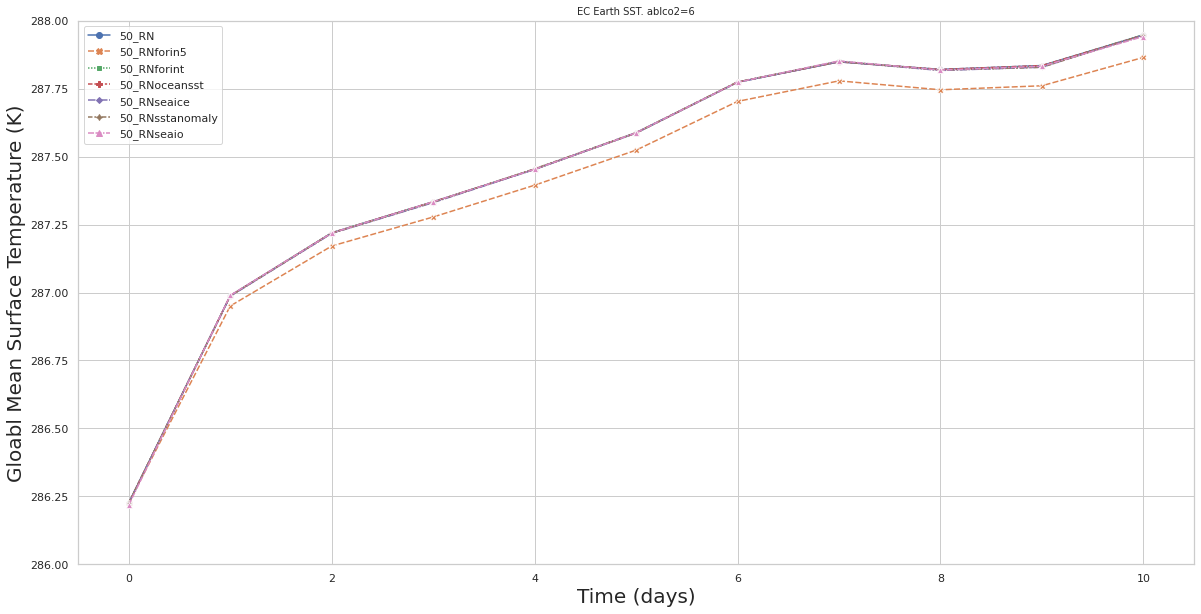

In [18]:
plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(286.0,288.0),
                   'y': 'temperature'}

df_hare = process_and_plot('hare/',plot_kwargs,pd.DataFrame())

The legend is a bit obscure, but the point is that if we interpolate the Climatological SST fields using the `forin5` subroutine at low precision, then we get this divergence - none of the other components matter. 

The output field `sstcl_ob` is used extensively later in when adjusting climatological fields over sea ice. 

---


# D. How do we do if we correct the pesky `forin5` ?

So what happens now if we take the full 50 bit solution, run all the coupling stuff at low precision **apart from `forin5`**. This is `50_RNcouplercorrected` in the figure below

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

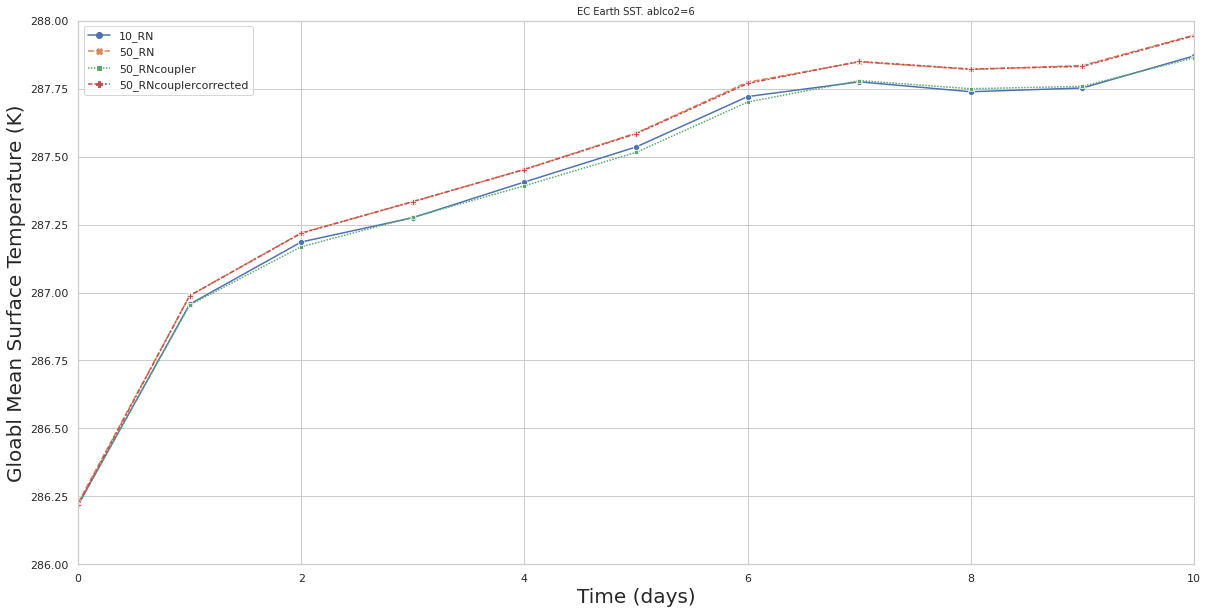

In [7]:
plot_kwargs = {'show_markers': True,
                   'xlimits': (0,10),
                    'ylimits':(286.0,288.0),
                   'y': 'temperature'}

df_flamingoV2 = process_and_plot('flamingoV2/',plot_kwargs,pd.DataFrame())

This plot shows that at early times the $\delta$ is driven entirely by the coupling (green line = blue line), but by introducing a correction to the `forin5` subroutine this delta vanishes over these timescales (red line = orange line). 

---

# E. What is the effect of `forin5` on longer timescales?

All the previous analysis was concerned with timescales on the order of days, and we have identified `forin5` as a potential failure point.

Lets now go back and do a **10 year run** for the badly behaved 10 year solution, **but with `forin5`at high precision**



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

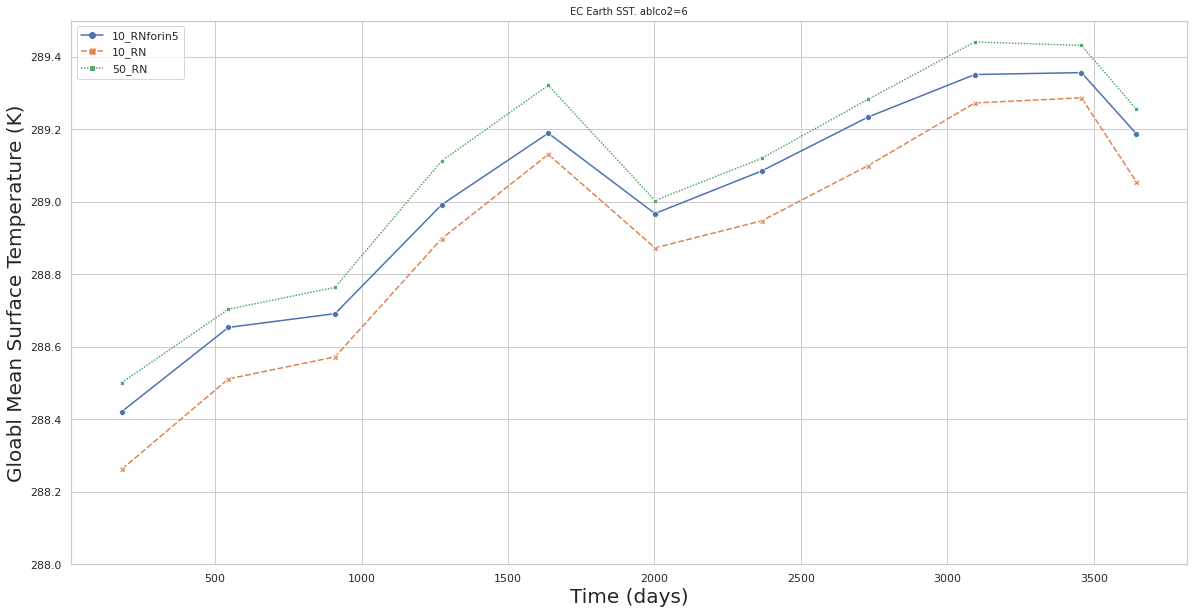

In [12]:
import matplotlib as mpl

plot_kwargs = {'show_markers': True,
                   'xlimits': None,
                    'ylimits':(288.0,289.5),
                   'y': 'temperature'}



backend_ =  mpl.get_backend() 
mpl.use("Agg")  # Prevent showing stuff
#The previous 10 year runs
df_10year_orig = process_and_plot('10yearL2/',plot_kwargs,pd.DataFrame())
#The new run
df_corrected = process_and_plot('ALPHA_10yr/',plot_kwargs,pd.DataFrame())
mpl.use(backend_) # Reset backend

#Bring together
df_all = pd.concat([df_10year_orig,df_corrected])

#Plot
df_selected = df_all.query('precision == "50_RN" | precision == "10_RN" | precision == "10_RNforin5"' )
plot_means(df_selected,364,plot_kwargs)

This is quite damming evidence - a large proportion (though not all) of the $\delta$ error in the 10bit solution comes from this `forin5` subroutine.

---

# F. Why does this subroutine cause such a problem? Why does SR not have the same issue?

Lets take the field `sstcl_ob` that is output by the `forin5` subroutine and see what it looks like:


In [21]:
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')

def process_subdir(f,t):
    
    #Return scalar field sstcl_ob slice at time t
    
    fname = f+'/model_output00001.nc'
    df = xr.open_dataset(fname)

    return df['sstcl_ob'][t] 



def plot_data(data,title,ylims):
    
    fig = plt.figure(figsize=[24,12])
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))

    quadmesh = data.plot(ax=ax, 
                         cmap='jet',
                         transform=ccrs.PlateCarree())
    ax.coastlines()
    
    
    quadmesh.set_clim(vmin=ylims[0], vmax=ylims[1])

    plt.title(title)
    plt.show()

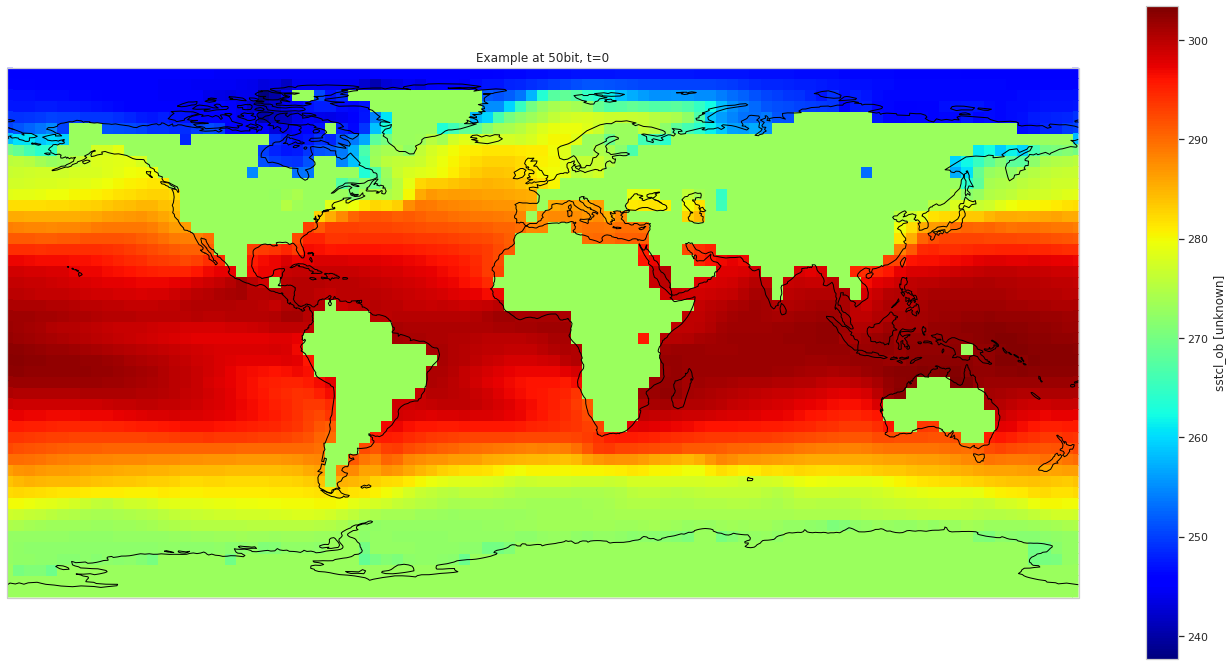

In [25]:
#Where is the data
node = 'forin5/'
root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'+node+'speedyoneforin5_L2_50_RN'

#Load to df
df50 = process_subdir(root,0)

#Plotit
ylims = (None, None)
plot_data(df50,'Example at 50bit, t=0',ylims)

So that is what the "truth" looks like at t=0. Out of interest we can also see what this looks like afer 10 days:

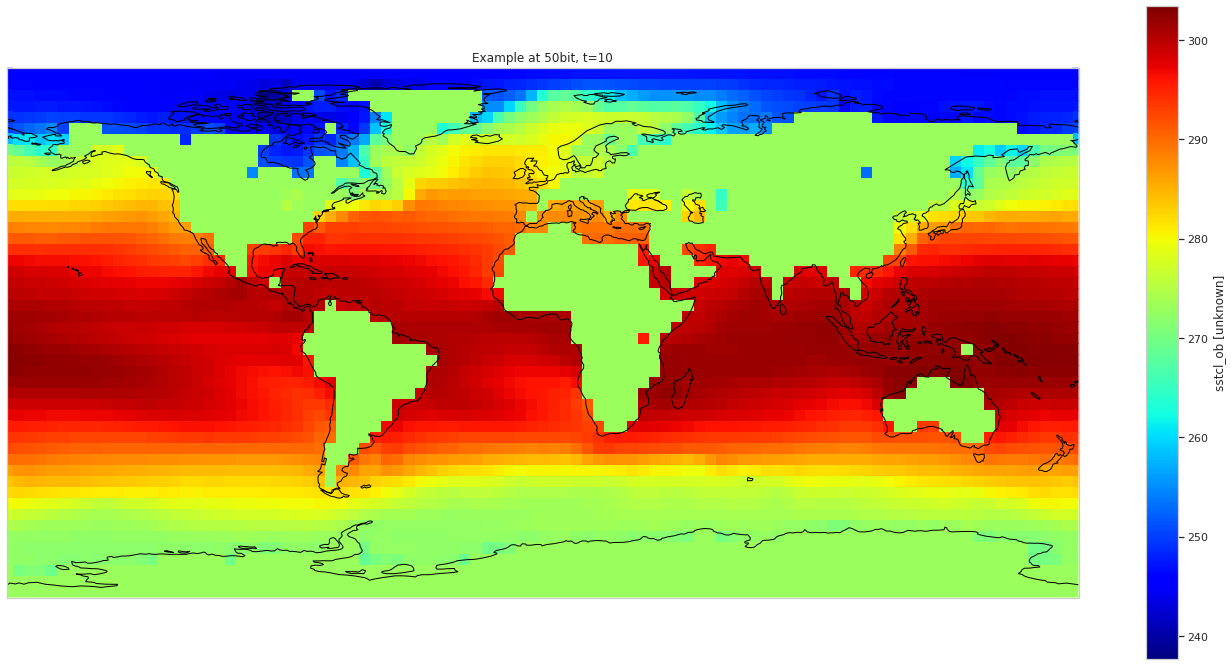

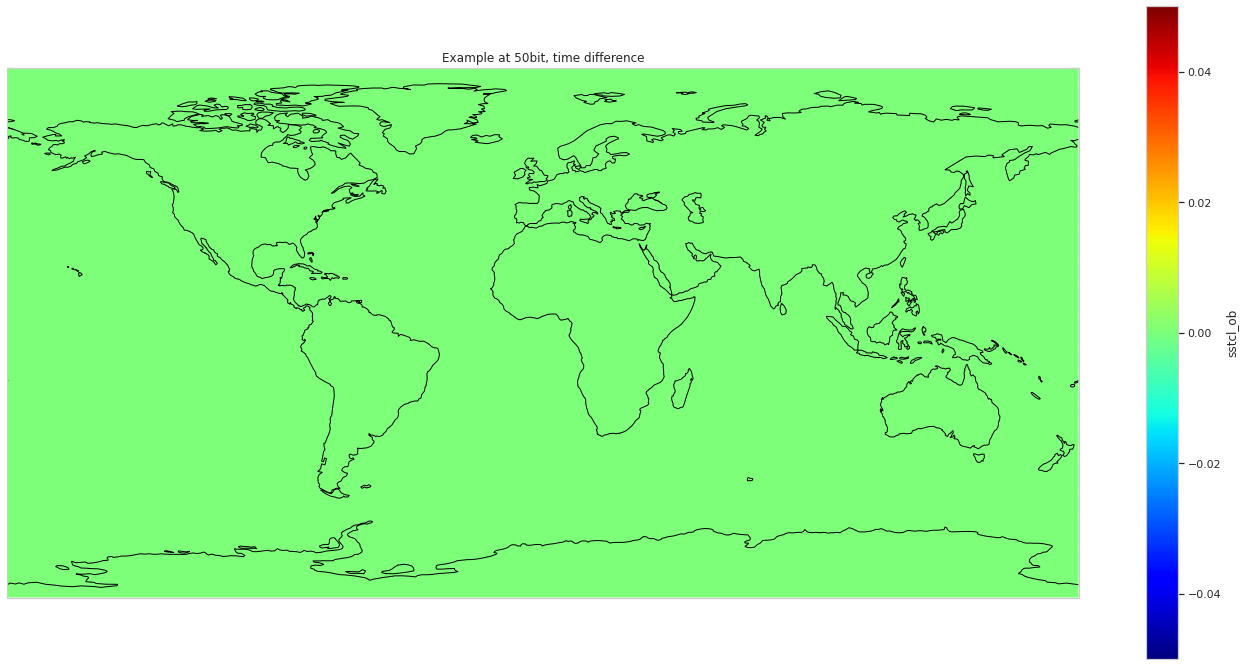

In [27]:
#Load to df
df50_t10 = process_subdir(root,10)

#Plotit
ylims = (None, None)
plot_data(df50_t10,'Example at 50bit, t=10',ylims)
plot_data(df50_t10 - df50,'Example at 50bit, time difference',ylims)

i.e. it is the same

Now lets look at how well the 10bit RN and 10bit SR solutions reproduce this scalar field. We take the full 50 bit solution, and just modify the `forin5` subroutine to run in reduced precision

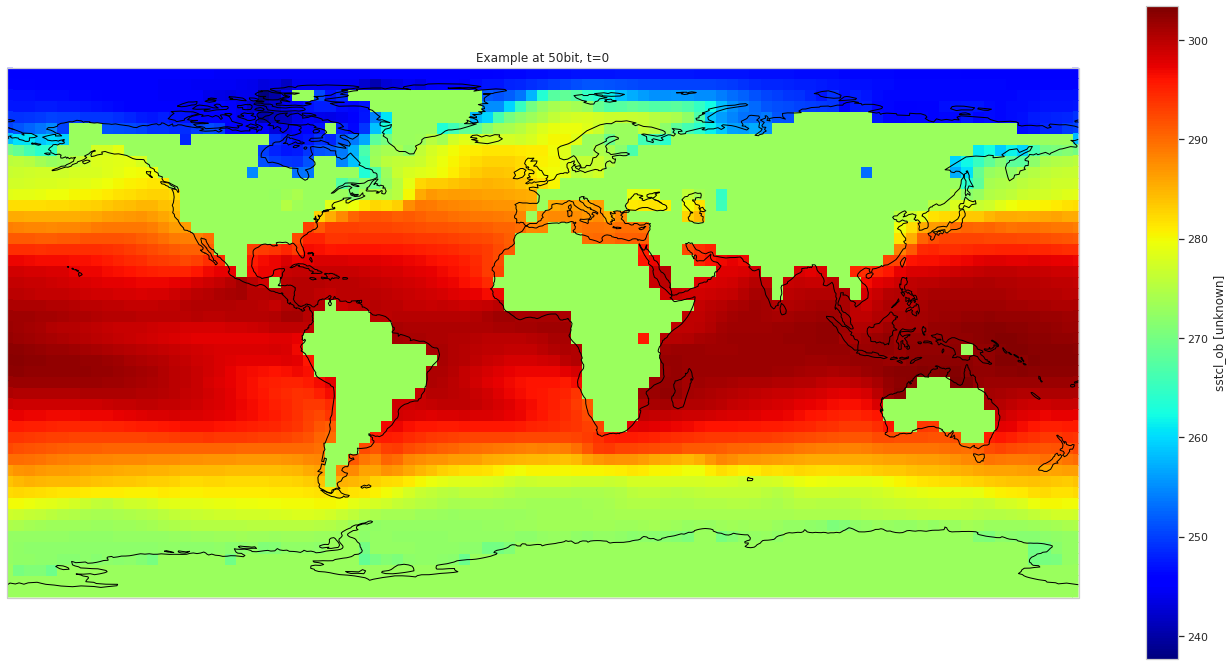

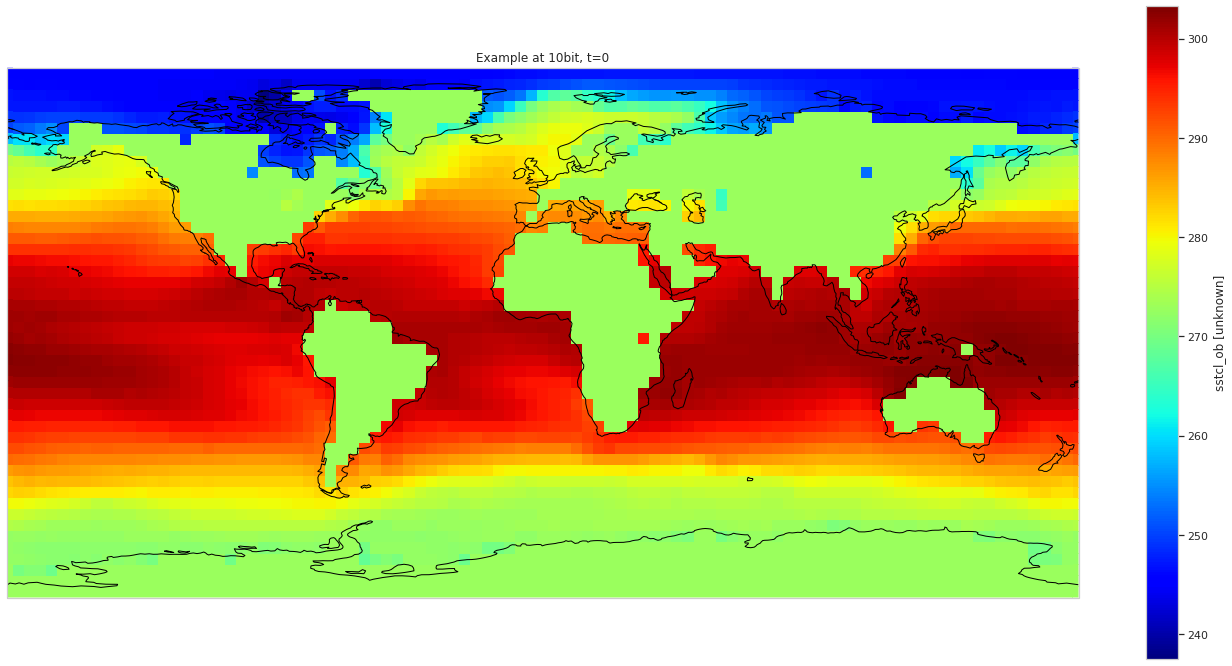

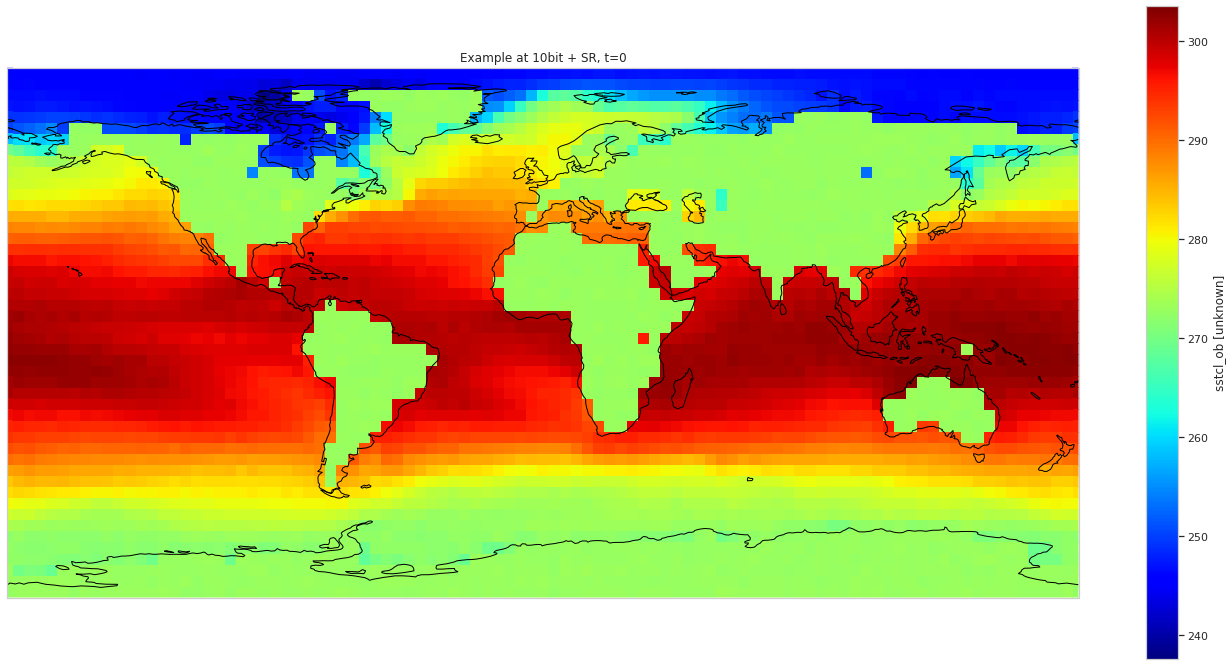

In [34]:
#Where is the data
node = 'forin5/'
root50 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'+node+'speedyoneforin5_L2_50_RN'
rootRN= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'+node+'speedyoneforin5_L2_50_RNforin'
rootSR= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'+node+'speedyoneforin5_L2_50_SRforin'


#Load to df
t = 5
df50RN = process_subdir(root50,t)
df10RN = process_subdir(rootRN,t)
df10SR = process_subdir(rootSR,t)



#Plotit
ylims = (None, None)
plot_data(df50RN,'Example at 50bit, t=0',ylims)
plot_data(df10RN,'Example at 10bit, t=0',ylims)
plot_data(df10SR,'Example at 10bit + SR, t=0',ylims)

They all look pretty similar to the eye. Lets now try instead plotting the **absolute error** between the low precision solutions (RN/SR) and the high precision at 50.

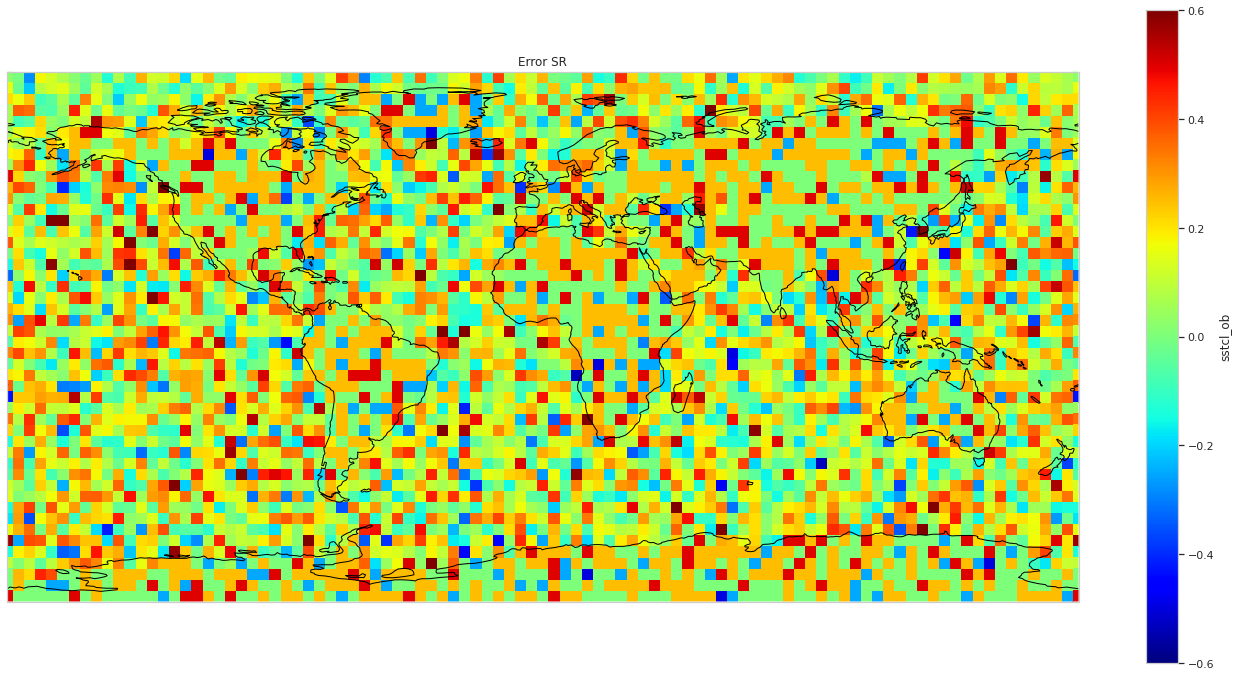

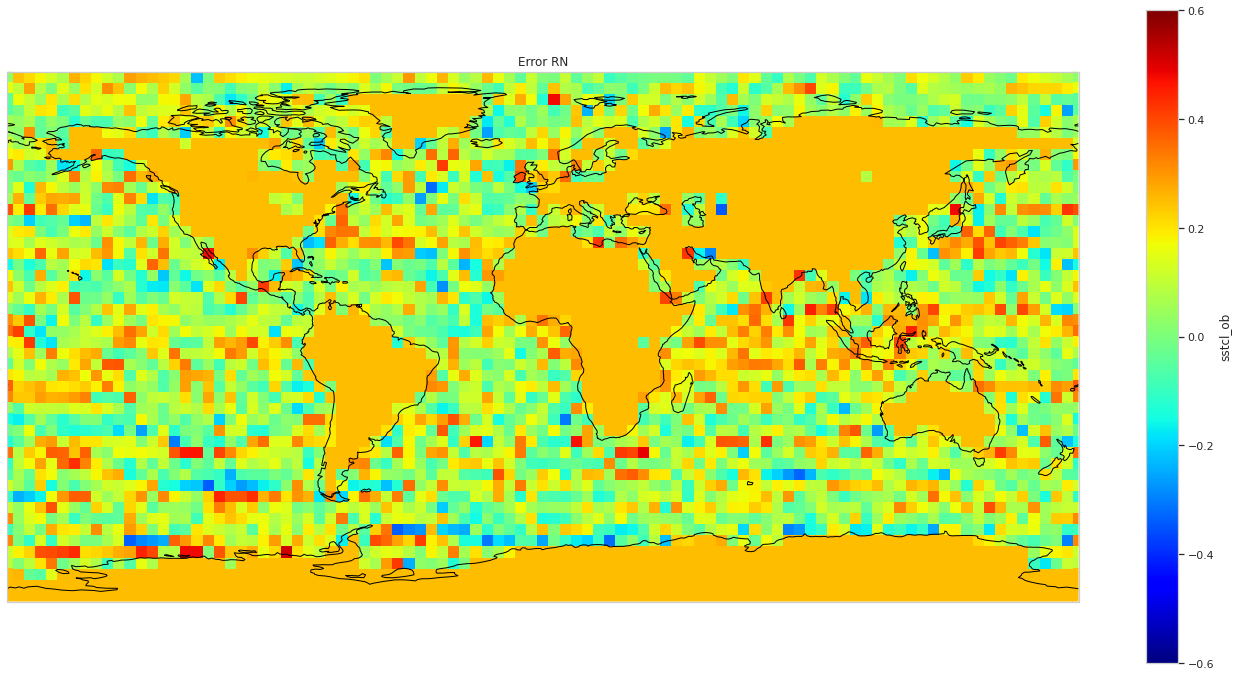

In [35]:
deltaSR = df50RN - df10SR
deltaRN = df50RN - df10RN

ylims = (-0.6, 0.6)
plot_data(deltaSR,'Error SR',ylims)
plot_data(deltaRN,'Error RN',ylims)

This is the crux of the issue: in the RN case there is a systematic error in `sstcl_ob` over the land, whereas in the SR case the error is much more stochastic!

---


# G. Can we have a closer look at this interpolation method?

Lets have a look not just at one day, but over each of the 10 days


0


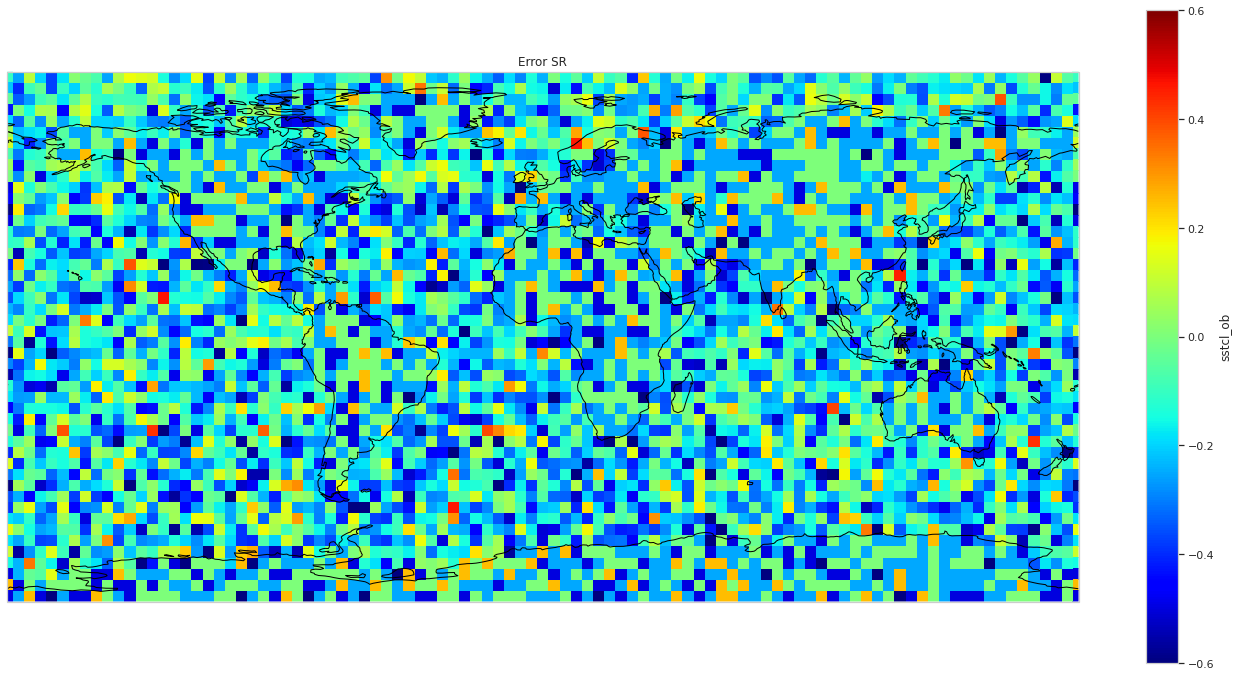

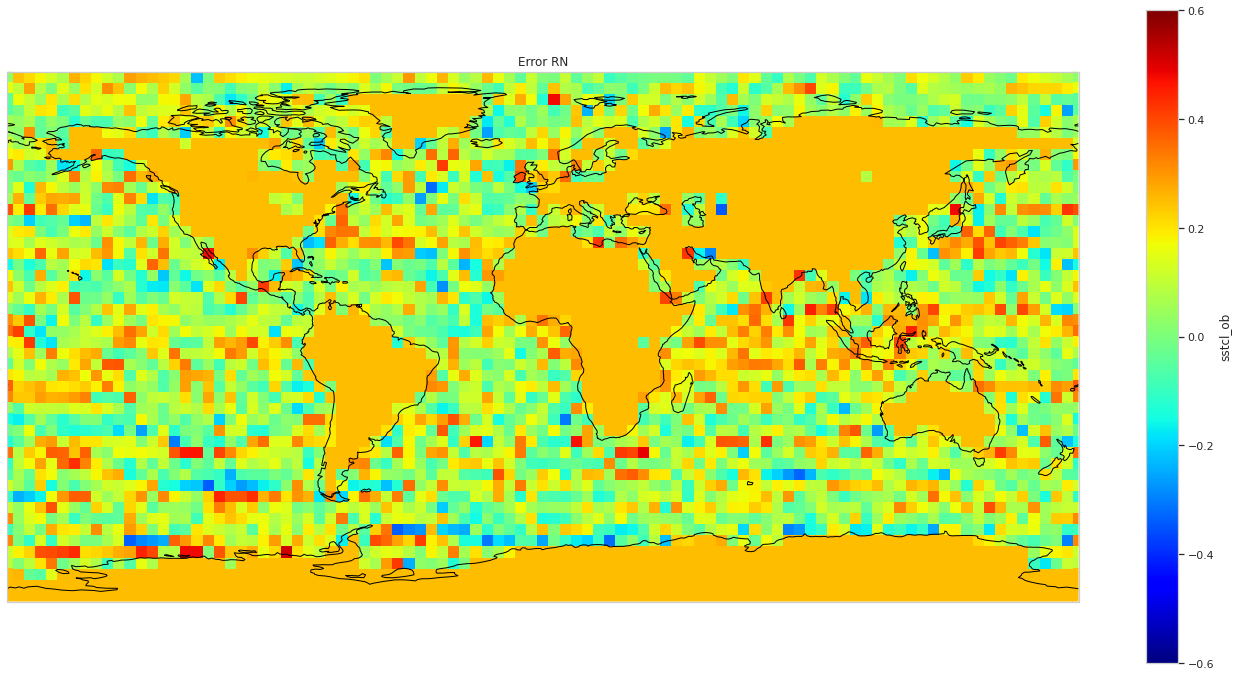

1


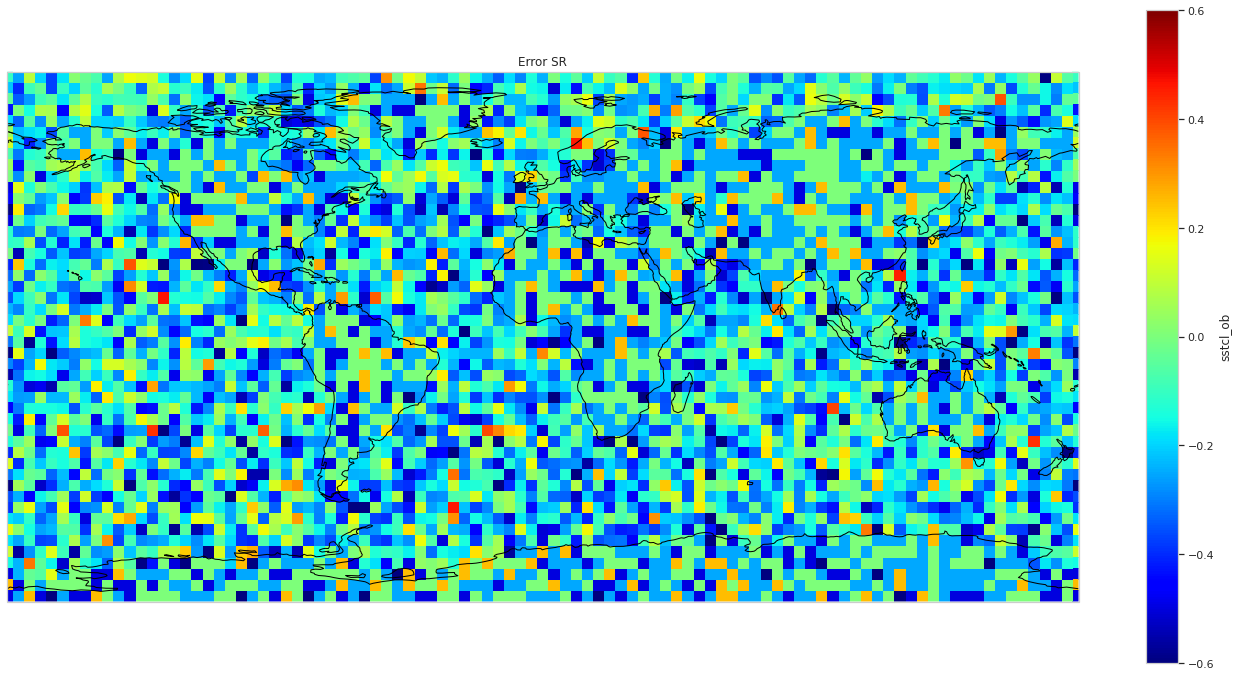

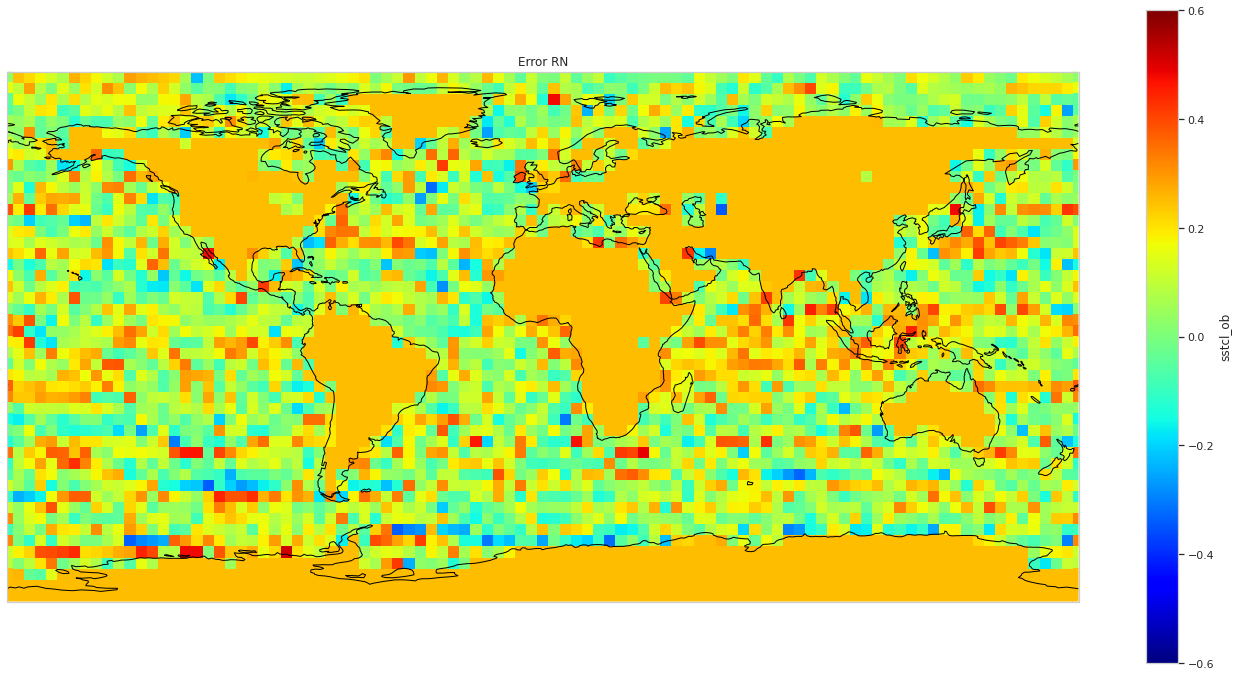

2


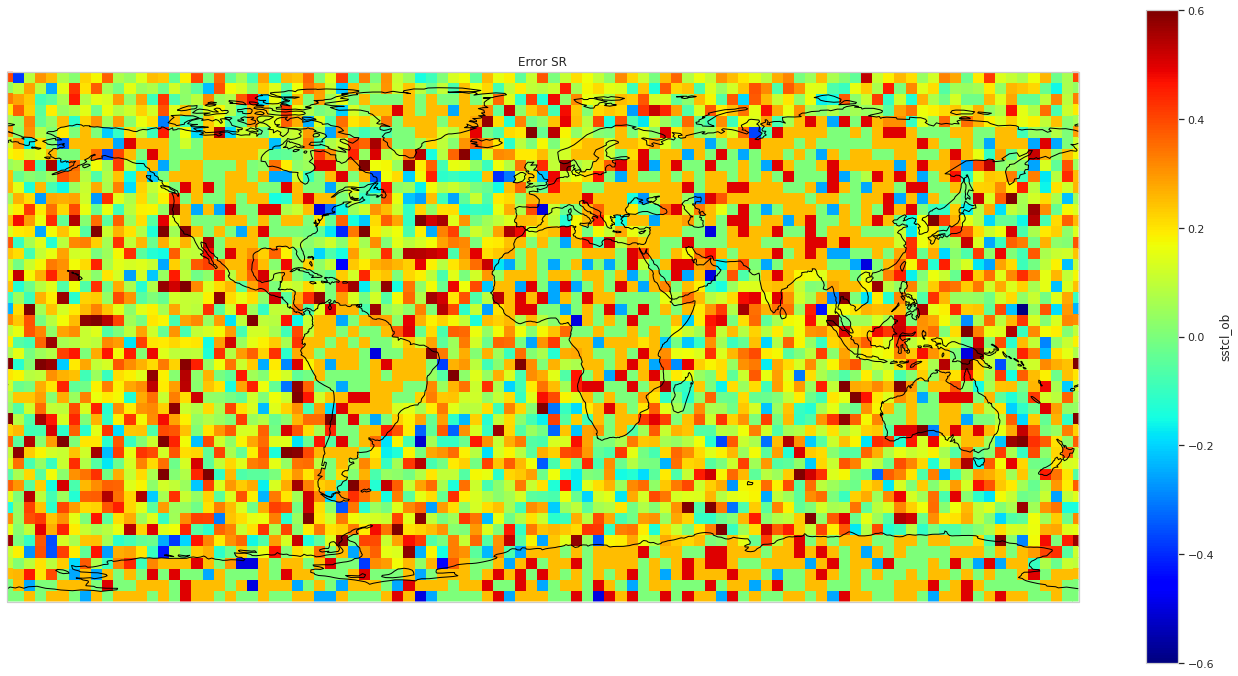

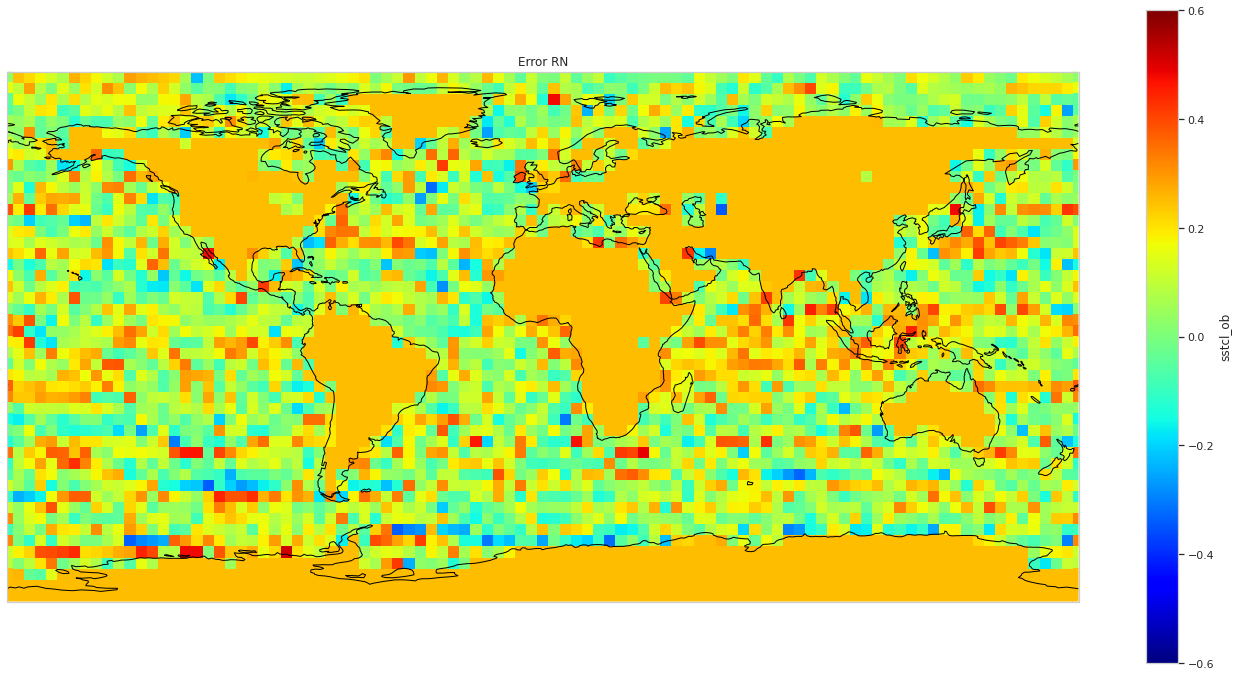

3


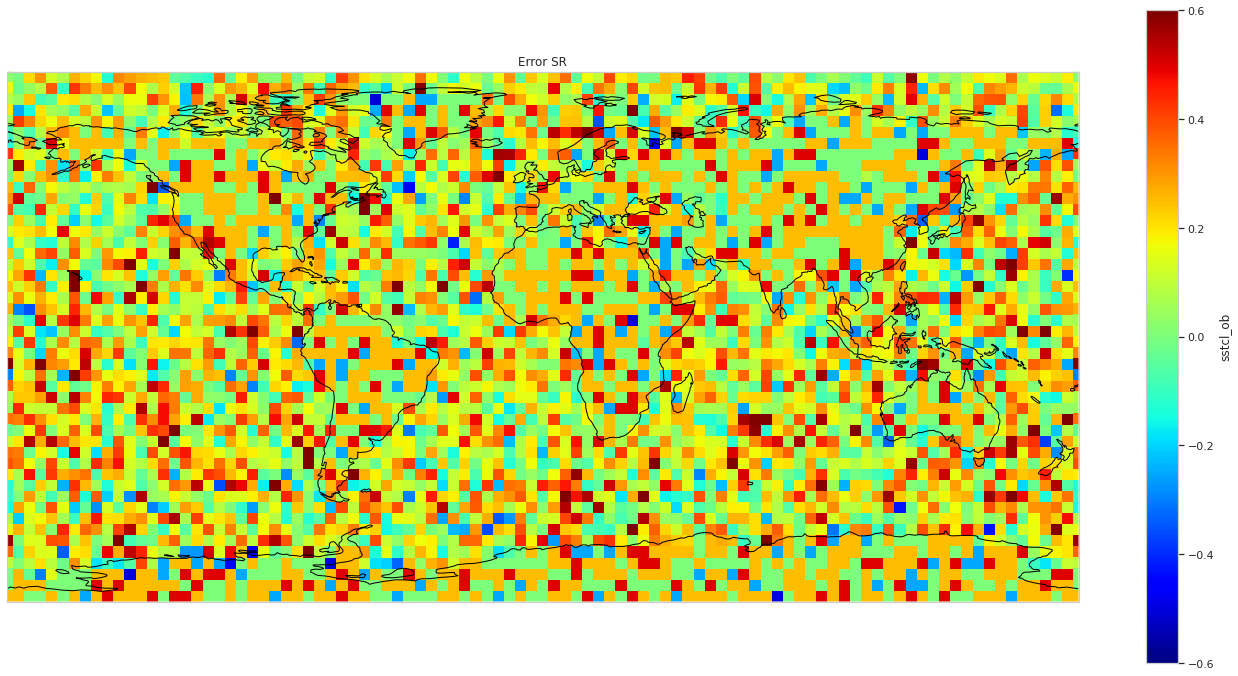

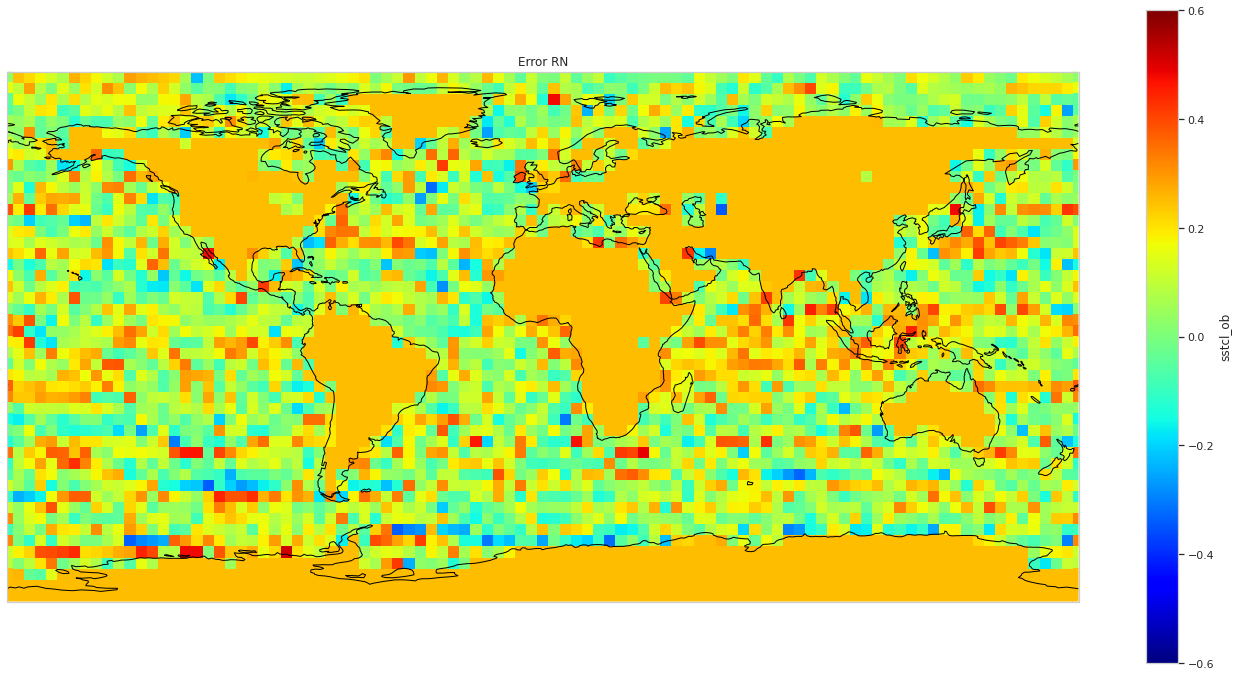

4


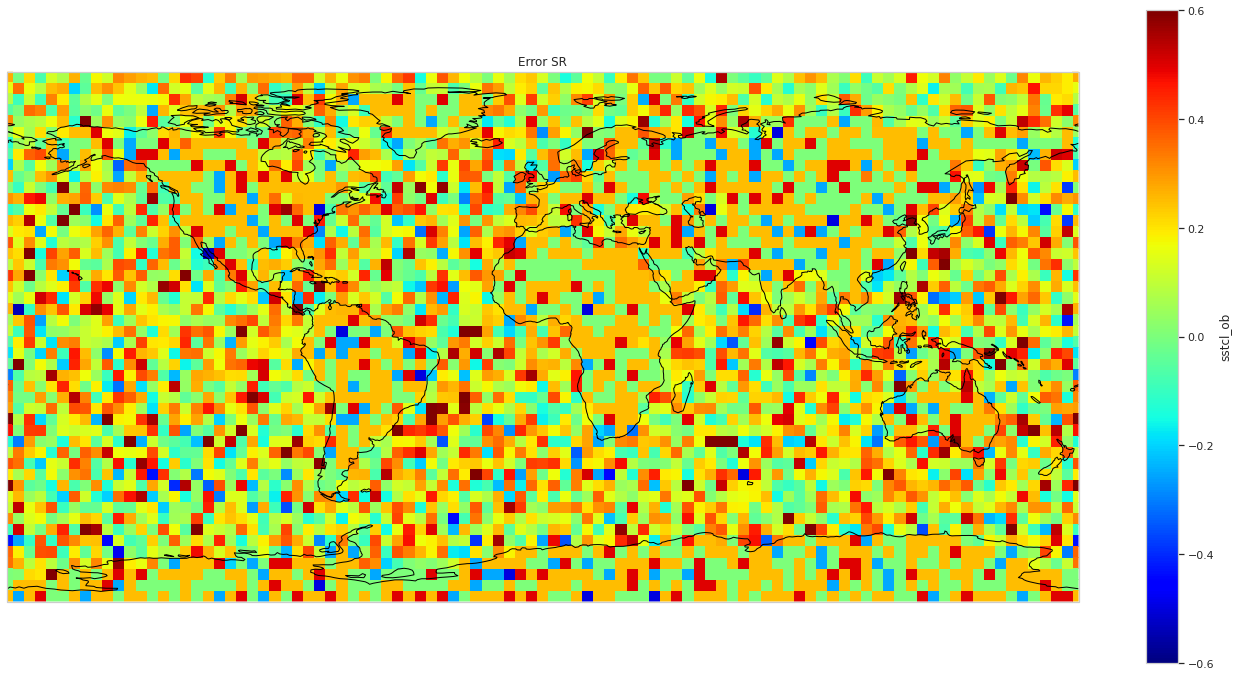

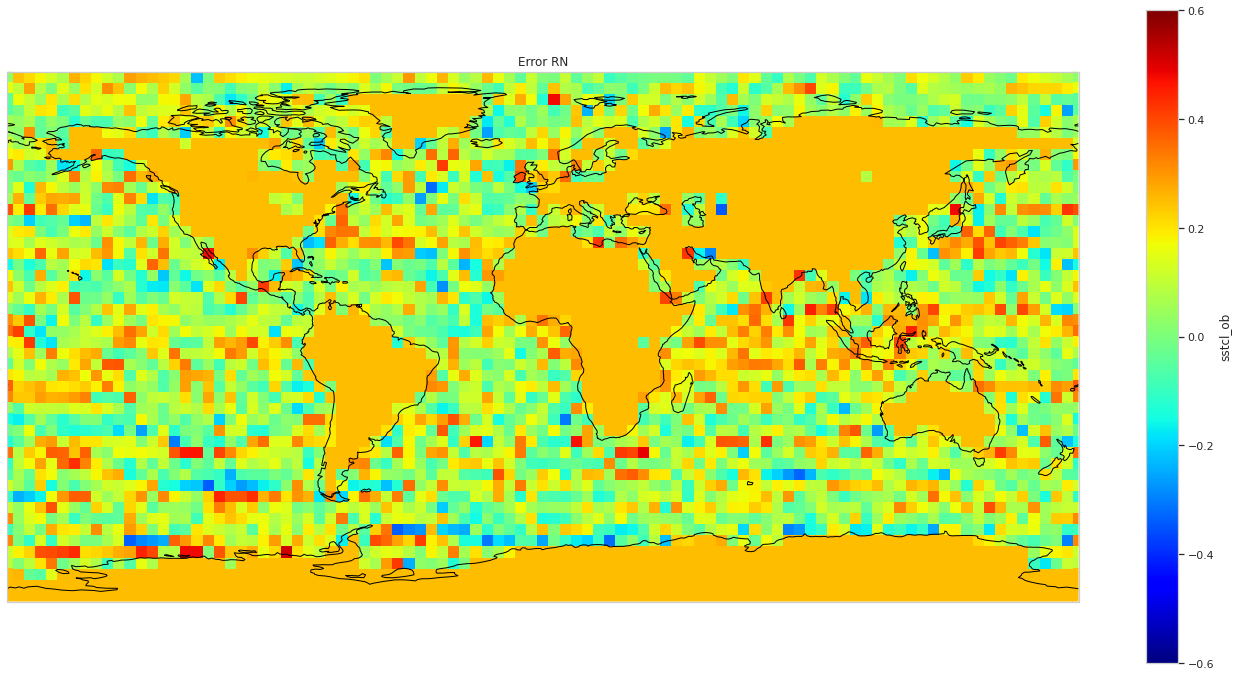

5


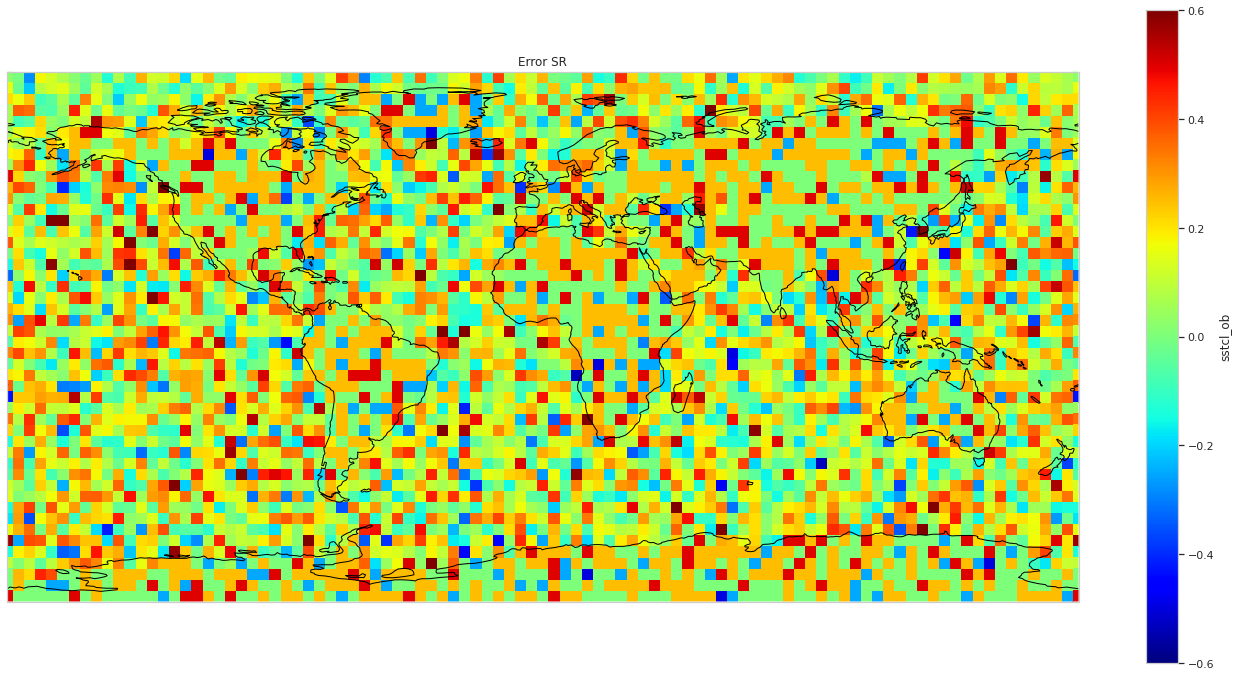

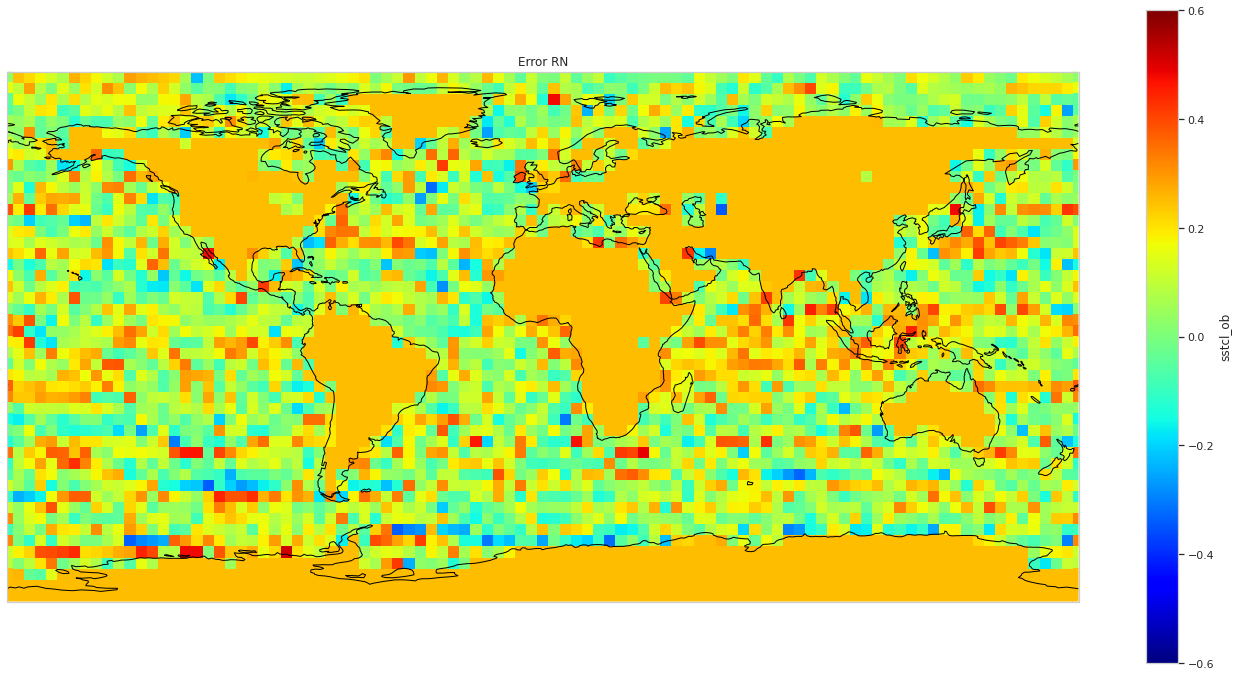

6


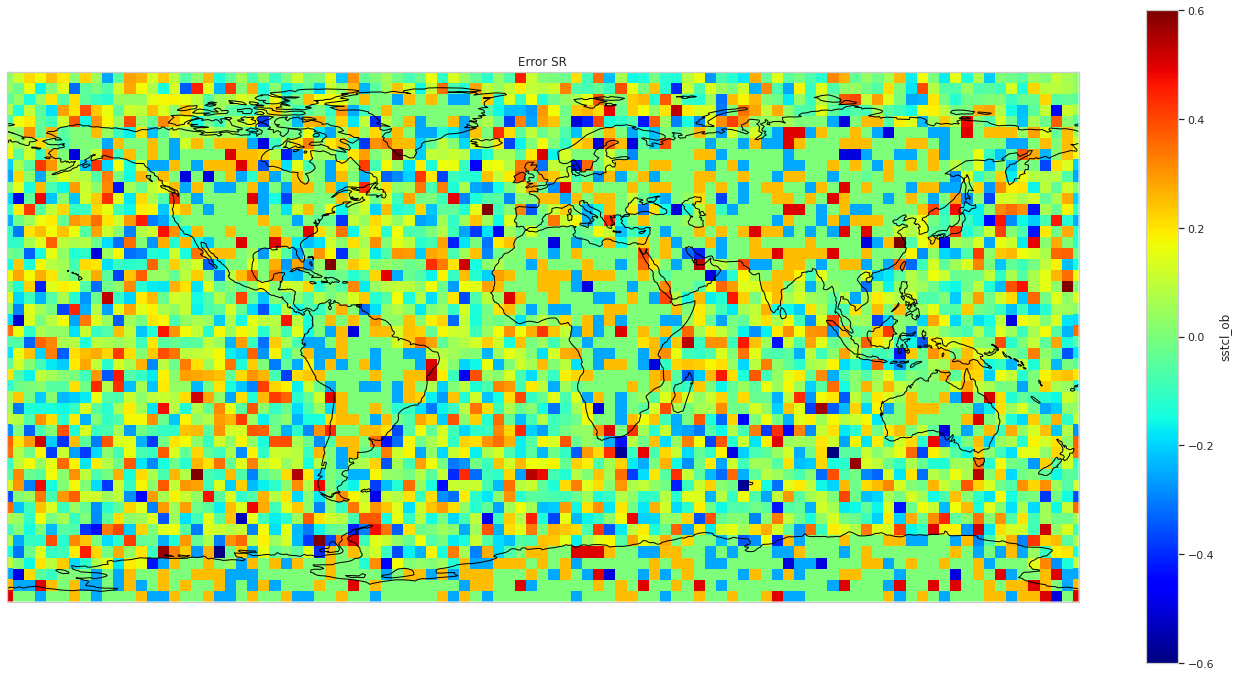

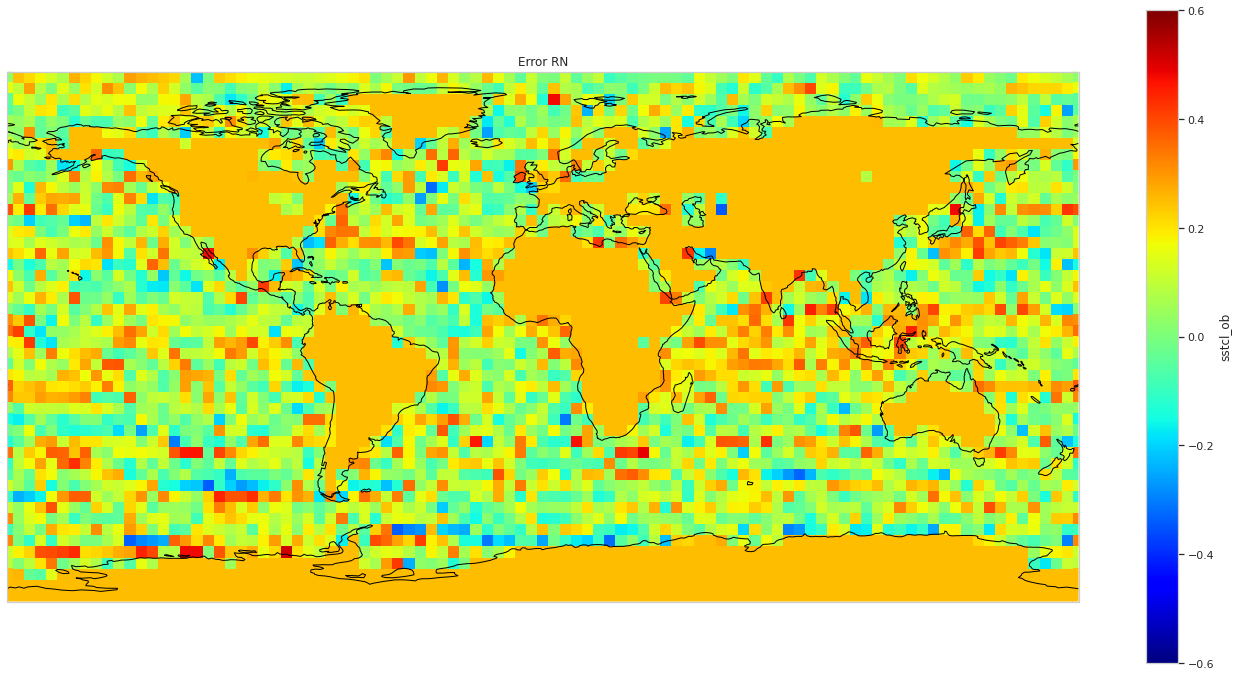

7


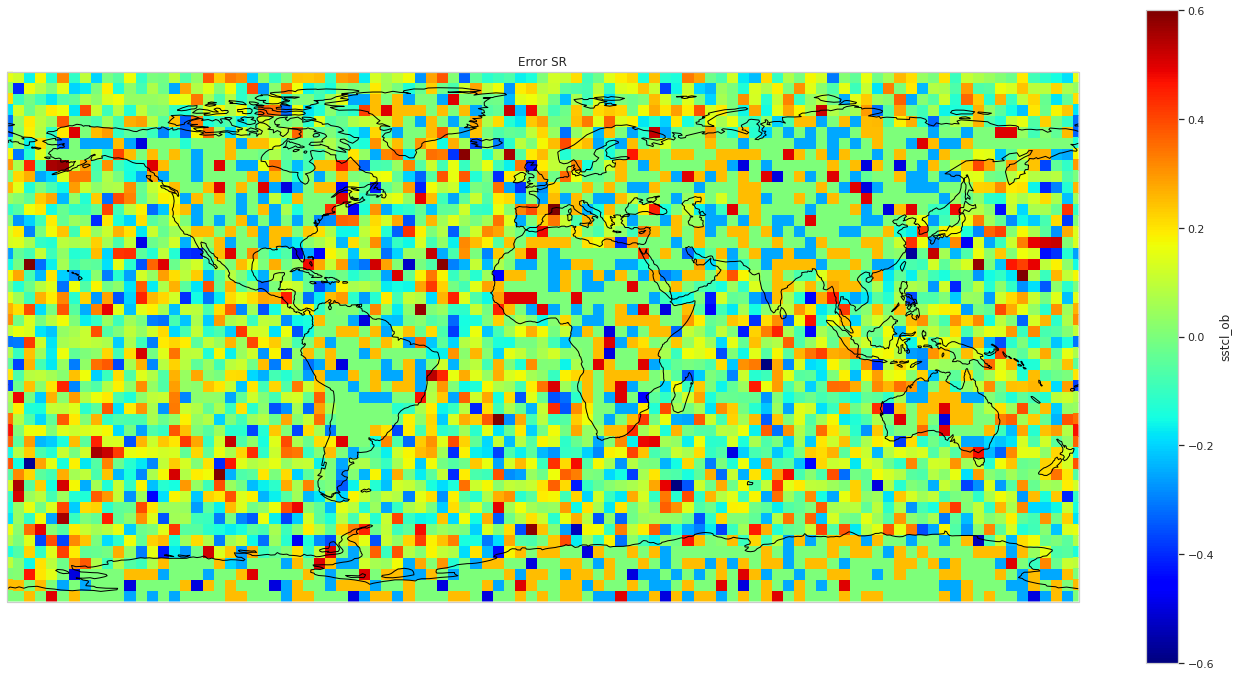

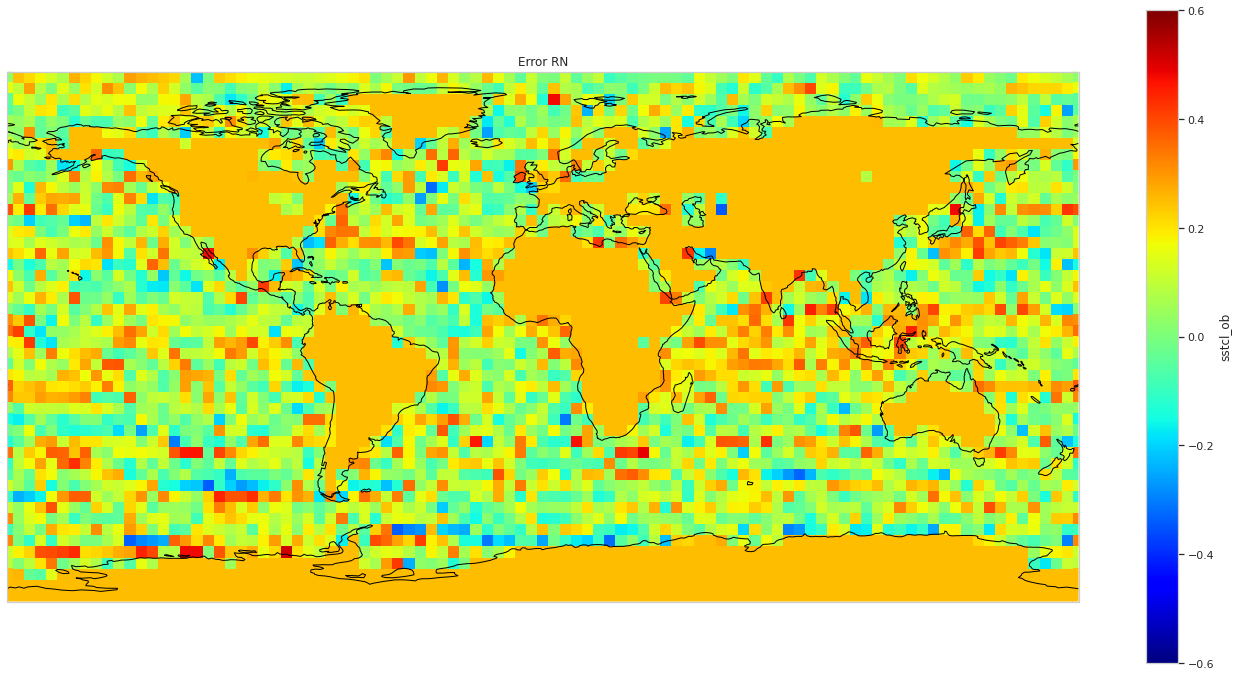

8


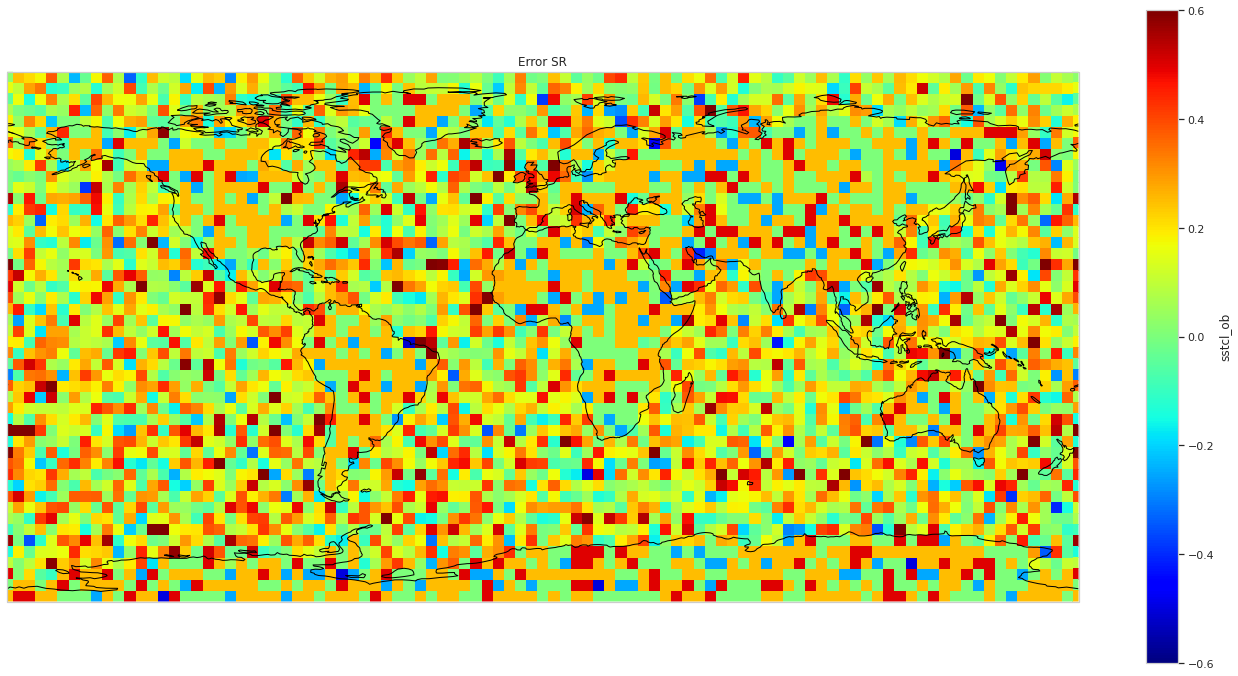

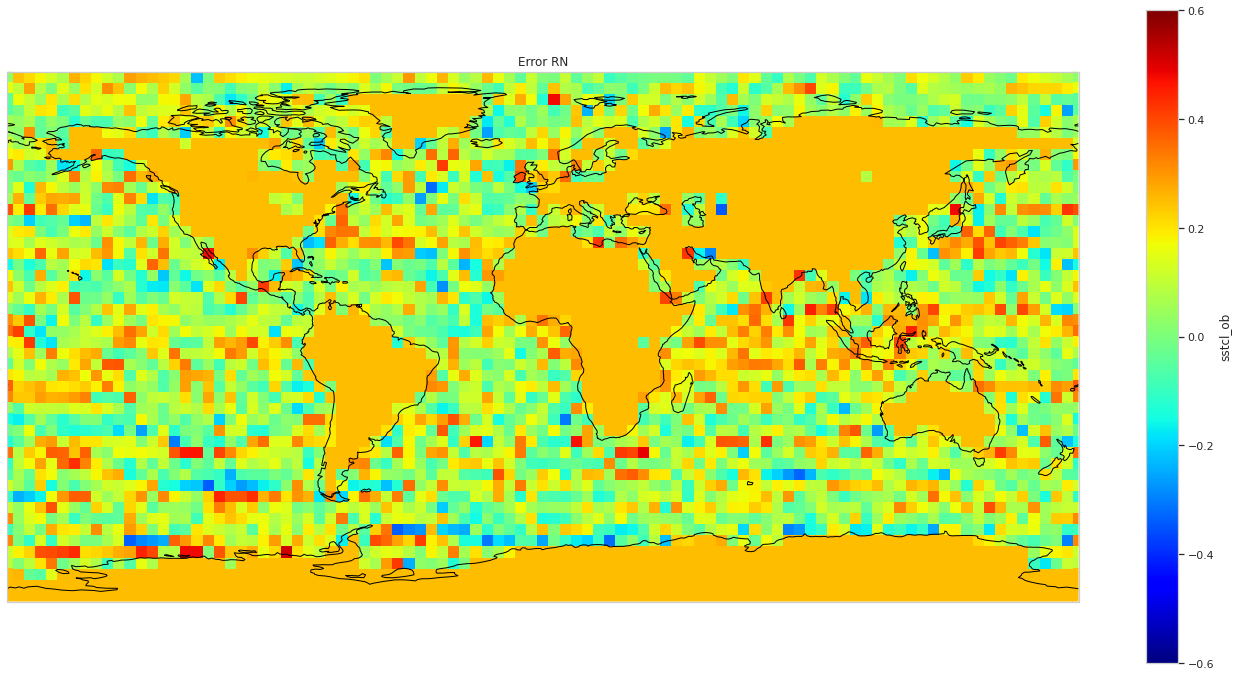

9


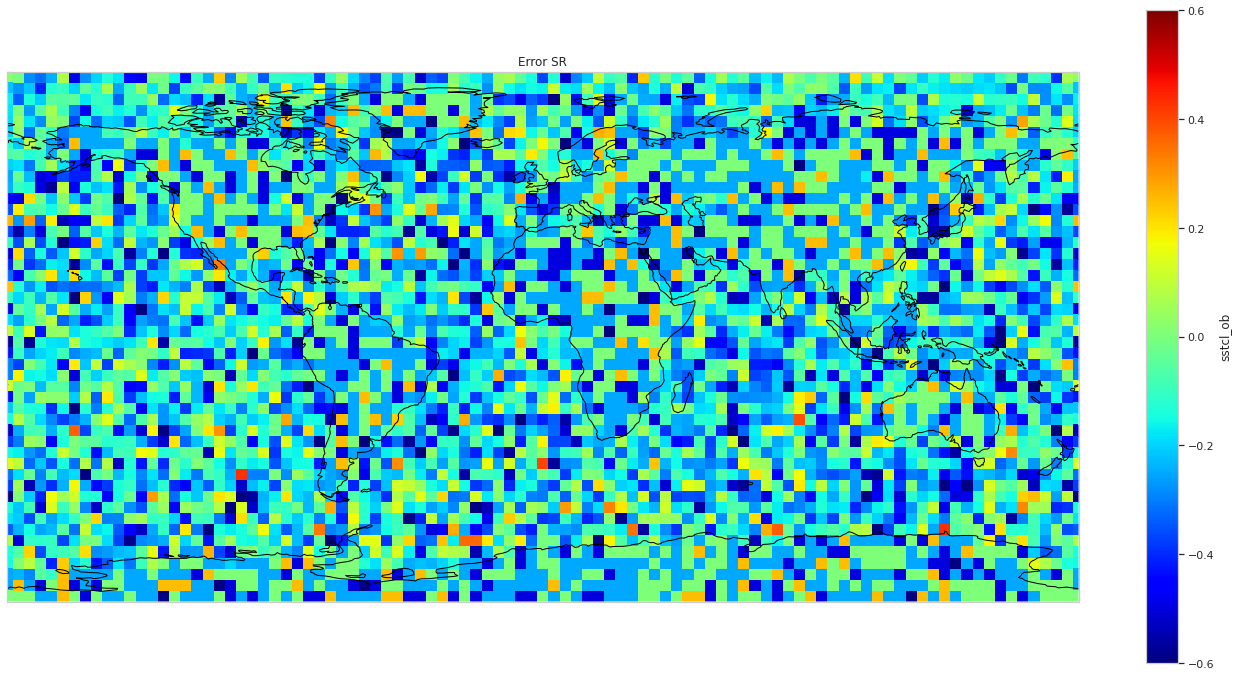

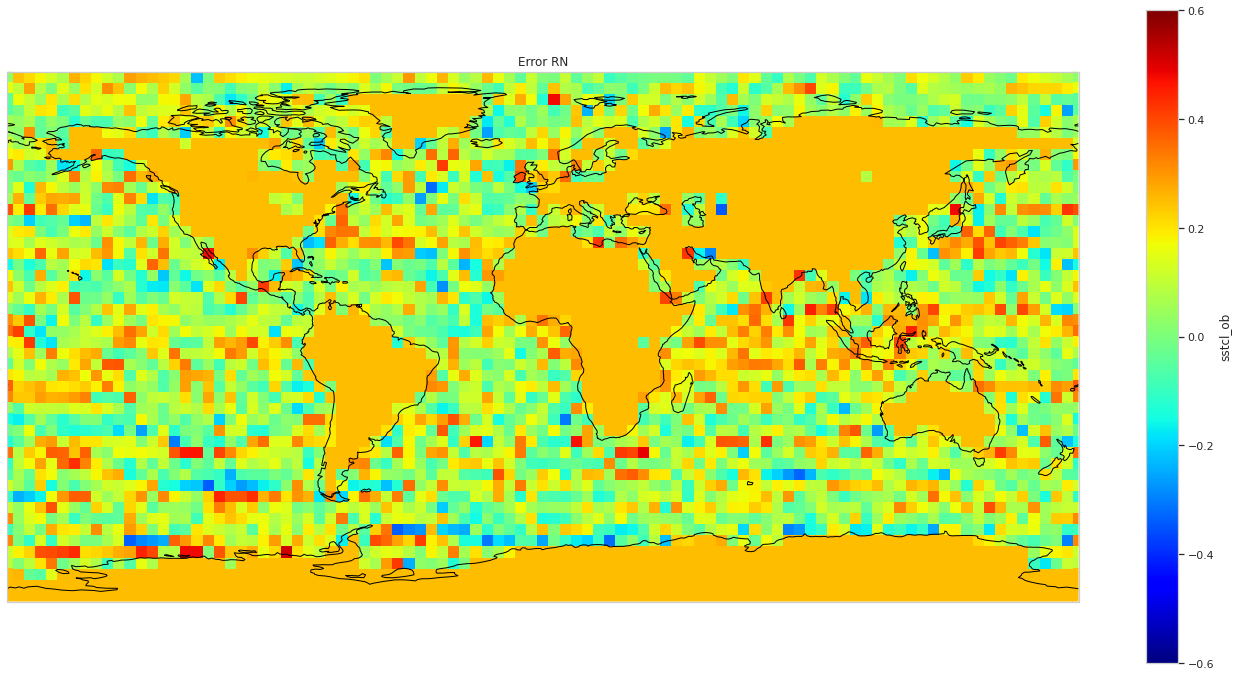

10


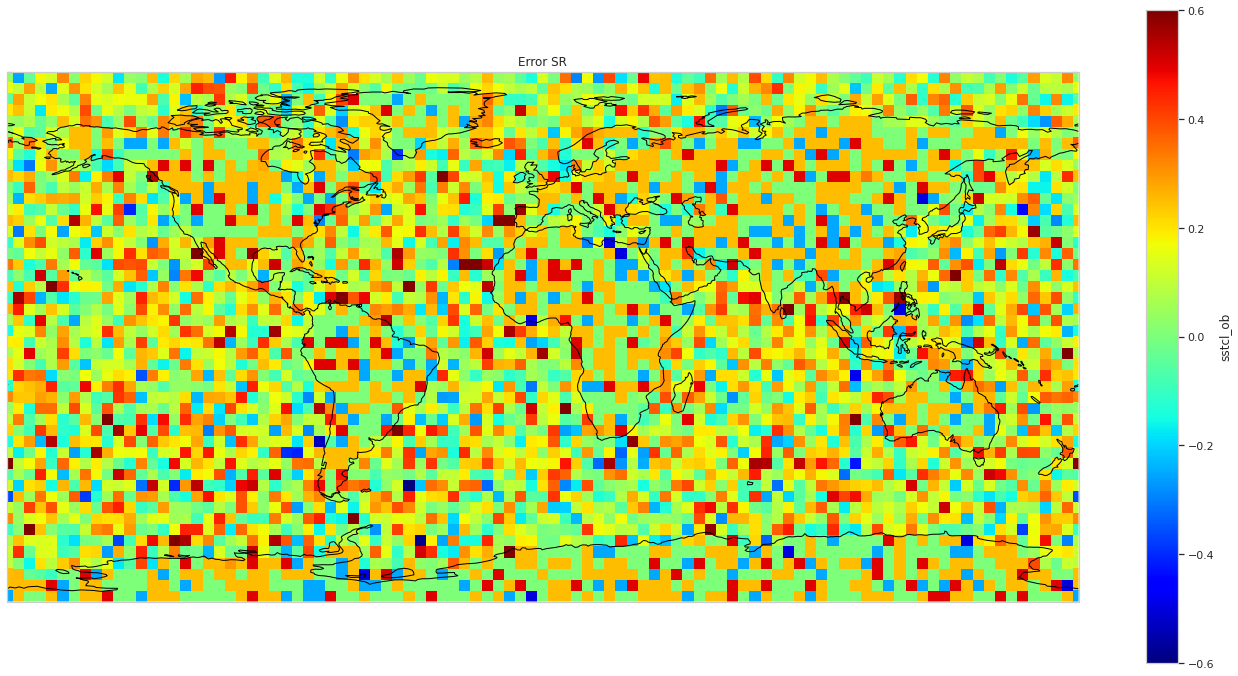

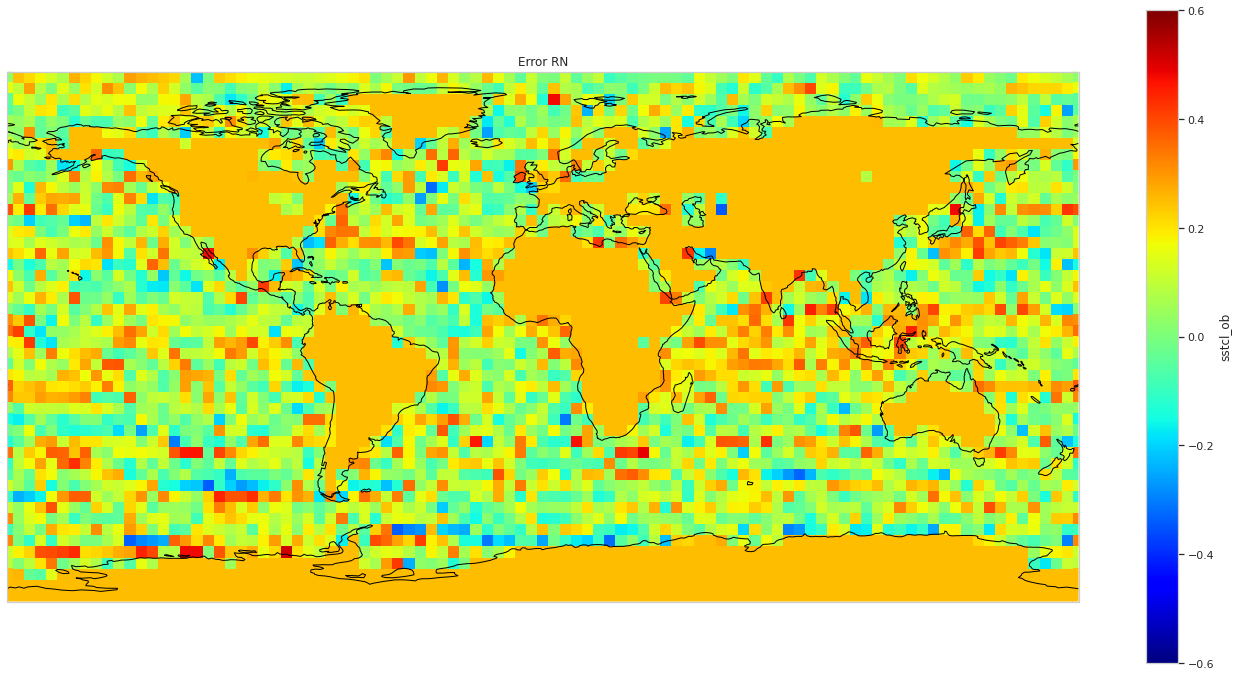

In [37]:
node = 'forin5/'
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'+node

subdirs = ['speedyoneforin5_L2_50_RN',
           'speedyoneforin5_L2_50_RNforin',
           'speedyoneforin5_L2_50_SRforin'
          ]



for i in range(11):
    print (i)
 
    df50RN = process_subdir(root+subdirs[0],i)
    df10RN =process_subdir(root+subdirs[1],i)
    df10SR =process_subdir(root+subdirs[2],i)
    
    deltaSR = df50RN - df10SR
    deltaRN = df50RN - df10RN


    ylims = (-0.6, 0.6)
    plot_data(deltaSR,'Error SR',ylims)
    plot_data(deltaRN,'Error RN',ylims)
    
    

We can see that the behaviour always occurs.

---
